In [1]:
# import the necessary packages
import os

from scipy.fft import fft2

import numpy as np
from PIL import Image
import cv2

import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

import stitching as st

from IPython.display import clear_output

In [2]:
imagePath = '/home/jack/Videos/map_2_images/'
imagePath = '/bucket/DaniU/Members/Jack Featherstone/Test/map_2_images/'

imageExtension = 'png'
fileTemplateName = 'image'

stitcherSettings = {'detector': 'orb',
                    'matcher_type': 'affine',
                    'confidence_threshold': .1,
                    'crop': False}

stitchKernel = 1
stitchImageSkip = 2
approxColumnSize = 1000
columnOverlap = 20

images = [imagePath + i for i in os.listdir(imagePath) if imageExtension in i]
imageIndexing = [int(img.split(fileTemplateName)[-1].split('.')[0]) for img in images]

images = np.array(images)[np.argsort(imageIndexing)]

def filter(img):
    return st.filterBackground(st.equalizeSpatialGradients(img), tolerance=.005)

100%|███████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


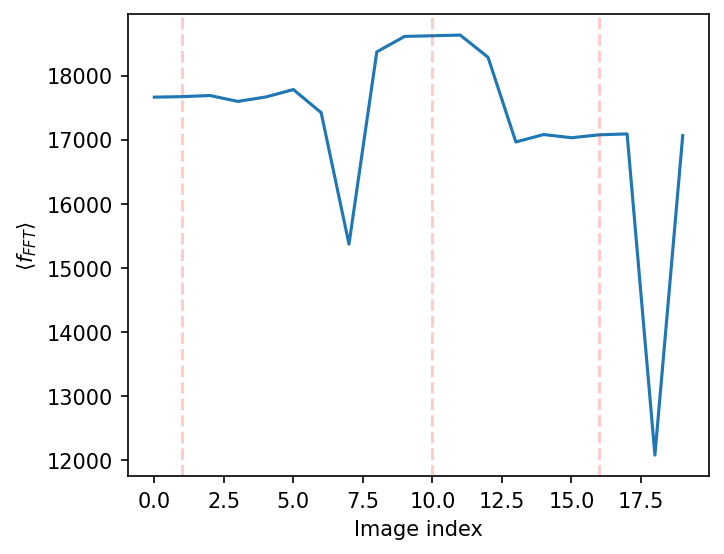

Found 3 stable images


In [3]:
stableImageIndices = st.identifyStableImages(images[:20], derThreshold=.05, debug=True)
print(f'Found {len(stableImageIndices)} stable images')

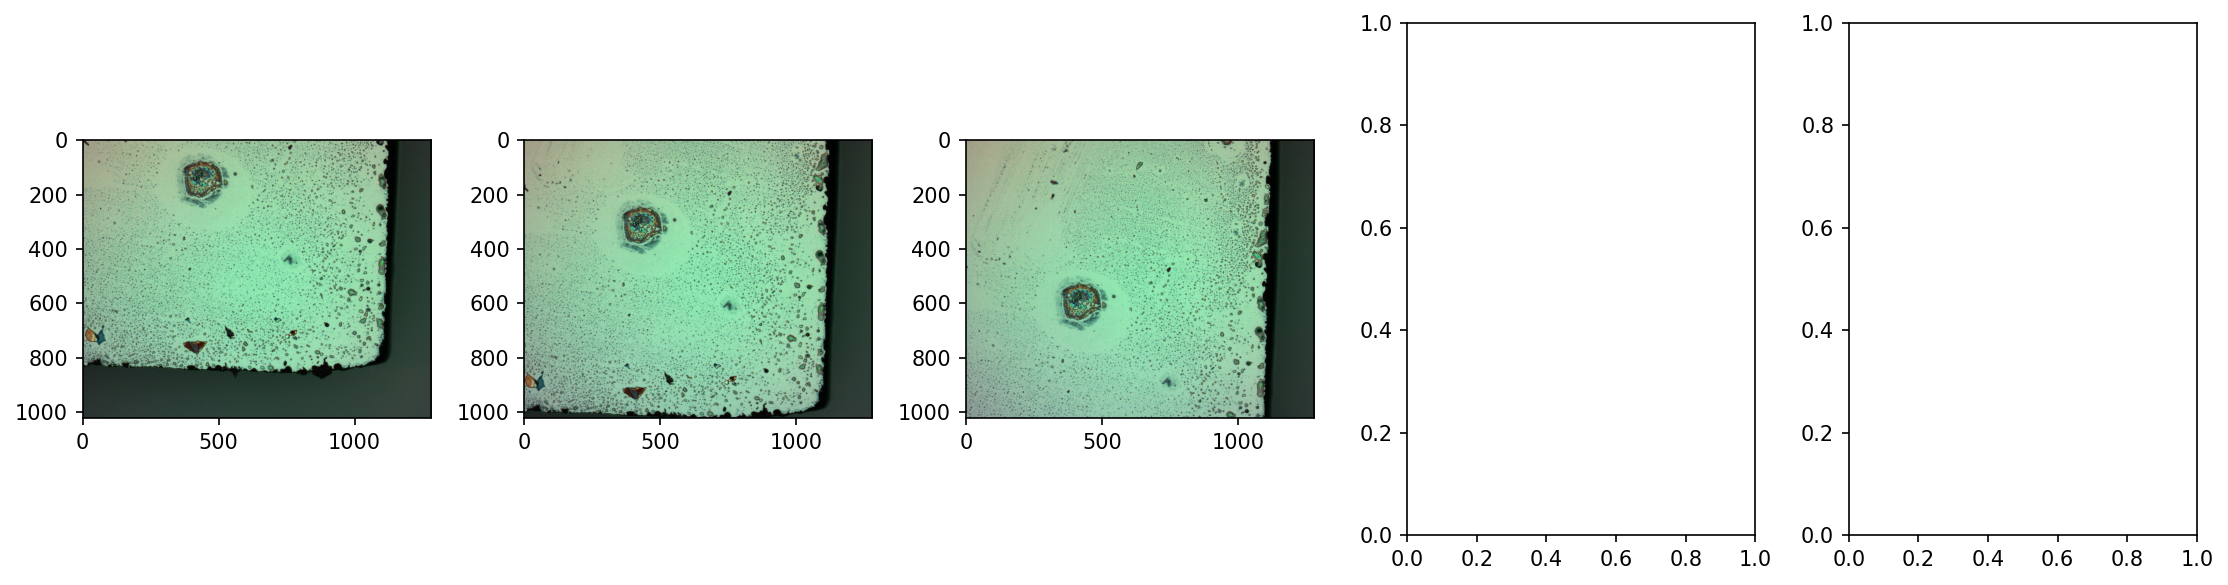

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(15, 4))

imgArr = [cv2.imread(images[i]) for i in stableImageIndices[:5]]

for i in range(len(imgArr)):
    ax[i].imshow(imgArr[i])

fig.tight_layout()
plt.show()

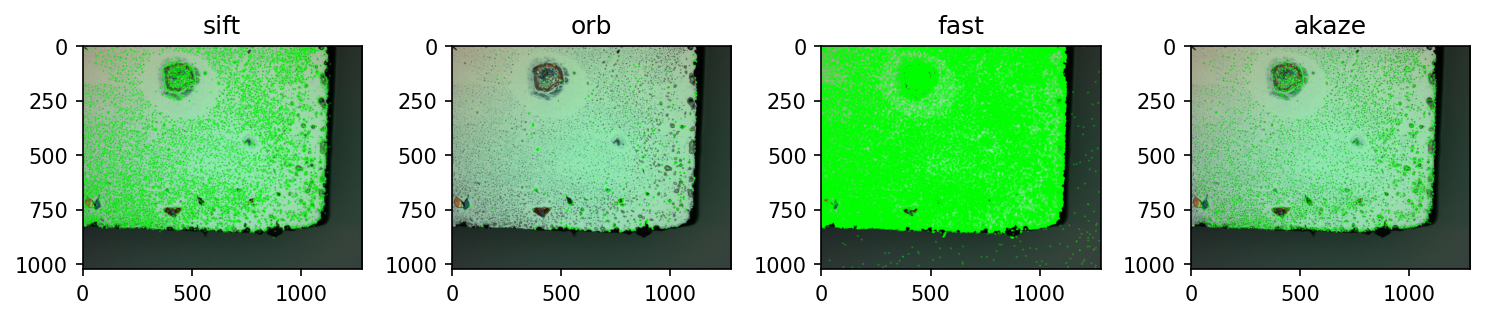

In [6]:
detectorTypes = ['sift', 'orb', 'fast', 'akaze']

fig, ax = plt.subplots(1, len(detectorTypes), figsize=(10,4))

for i in range(len(detectorTypes)):
    fd = st.FeatureDetector(detectorTypes[i])
    features = fd.detect_features(np.mean(imgArr[0], axis=-1))
    
    ax[i].imshow(st.FeatureDetector().draw_keypoints(imgArr[0], features))
    ax[i].set_title(detectorTypes[i])
    
fig.tight_layout()
plt.show()

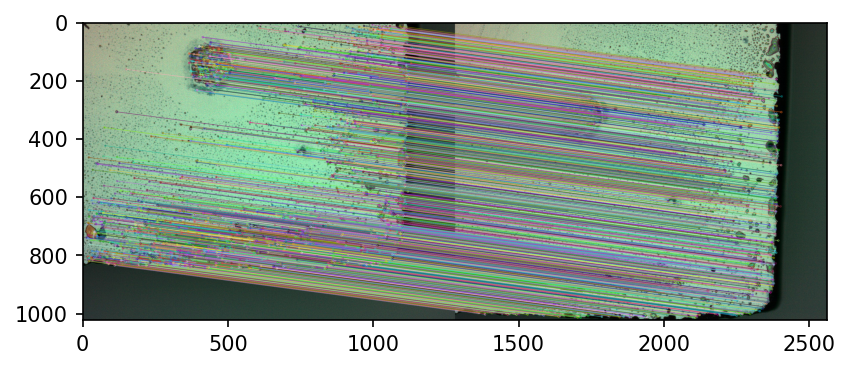

In [5]:
fd = st.FeatureDetector('sift')
features = [fd.detect_features(np.mean(imgArr[i], axis=-1)) for i in range(3)]

matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
matches = matcher.knnMatch(features[0]["descriptors"], features[1]["descriptors"], k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])
        
# cv.drawMatchesKnn expects list of lists as matches.
result = cv2.drawMatchesKnn(imgArr[0], features[0]["keypoints"],
                         imgArr[1], features[1]["keypoints"],
                         good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(result)
plt.show()

In [7]:
stitchedOffsets = [[0,0]]
stitchedOffsetErrors = [0]
stitchedRotations = [0]

matcherType = 'flann'

imgArr = [cv2.imread(images[i]) for i in stableImageIndices]

fd = st.FeatureDetector('sift')
features = [fd.detect_features(np.mean(imgArr[i], axis=-1)) for i in tqdm.tqdm(range(len(imgArr)))]

for i in tqdm.tqdm(range(len(imgArr)-1)):

    if matcherType == 'flann':
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
        matches = matcher.knnMatch(features[i]["descriptors"], features[i+1]["descriptors"], k=2)
    else:
        # BFMatcher with default params
        matcher = cv2.BFMatcher()
        matches = bf.knnMatch(features[i]["descriptors"], features[i+1]["descriptors"], k=2)

    # Apply ratio test
    good = []
    ratioThreshold = .5
    for m,n in matches:
        if m.distance < ratioThreshold*n.distance:
            good.append(m)

    da = []
    dr = []

    for match in good:
        keypoint1 = features[i]["keypoints"][match.queryIdx]
        keypoint2 = features[i+1]["keypoints"][match.trainIdx]

        dr.append(np.array(keypoint1.pt) - np.array(keypoint2.pt))
        da.append(keypoint1.angle - keypoint2.angle)

    # Fix periodicity
    da = np.where(np.array(da) > 180, np.array(da) - 360, da)
    da = np.where(np.array(da) < -180, np.array(da) + 360, da)

    dr = np.array(dr)
    
    stitchedOffsets.append(np.median(dr, axis=0))
    stitchedOffsetErrors.append(np.sqrt(np.std(dr[:,0])**2 + np.std(dr[:,1])**2))
    stitchedRotations.append(np.median(da))
    
stitchedOffsets = np.array(stitchedOffsets)
stitchedRotations = np.array(stitchedRotations)

100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.60it/s]


In [11]:
absoluteOffsets = np.cumsum(stitchedOffsets, axis=0)
imgSizes = [img.shape[:2] for img in imgArr]

blender = st.Blender('multiband')
blender.prepare(absoluteOffsets, imgSizes)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resultRoi'
> Overload resolution failed:
>  - resultRoi() missing required argument 'images' (pos 2)
>  - Can't parse 'corners'. Sequence item with index 0 has a wrong type


In [80]:
def cullOutliers(x, w=2):
    d = np.abs(x - np.median(x))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return x[s<w]

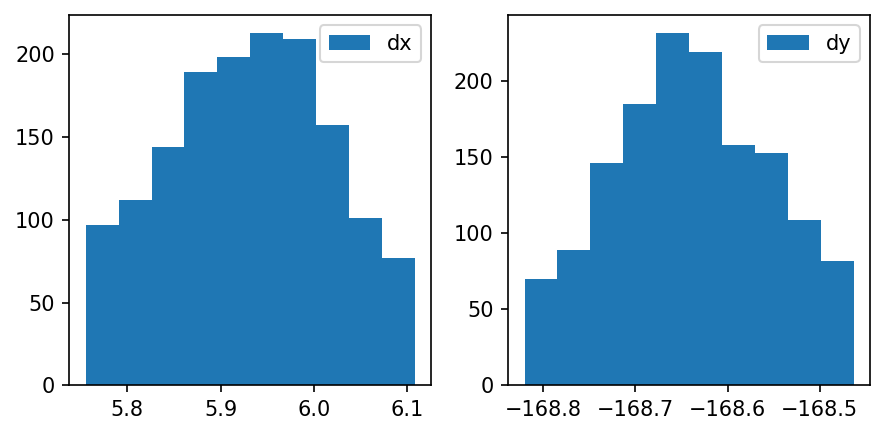

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].hist(cullOutliers(dr[:,0]), label='dx')
ax[0].legend()
ax[1].hist(cullOutliers(dr[:,1]), label='dy')
ax[1].legend()

fig.tight_layout()
plt.show()

In [66]:
np.median(da)

-0.02926158905029297

In [45]:
features[0]["keypoints"][485].pt

(713.5438842773438, 237.56460571289062)

In [44]:
features[1]["keypoints"][1910].angle

164.92678833007812